# Super TML
---
Implementation of Pytorch [Super TML: Two-dimensional word embedding for precognition of structured tabular data](https://arxiv.org/abs/1903.06246) with data from [Drinking_Water_Potability]

![image.png](./paper.png)

## Imports & Settings

In [111]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [112]:
from data_preparation import data_to_image
from model import model_res
from train import train_model

torch.backends.cudnn.enabled = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [114]:
df = pd.read_csv('../drinking_water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [115]:
# Imputación
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Inicializar el imputador iterativo
imputer = IterativeImputer()

# Entrenar el imputador en los datos con valores faltantes
imputer.fit(df)

# Transformar los datos para imputar los valores faltantes
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

# Verificar que no hay valores faltantes después de la imputación
print("Valores faltantes después de la imputación:")
print(df_imputed.isnull().sum())

# Outliers

from sklearn.ensemble import IsolationForest

# Seleccionar solo las columnas numéricas
numeric_columns = df_imputed.select_dtypes(include=['float64', 'int64'])

# Inicializar y ajustar el modelo Isolation Forest
clf = IsolationForest(random_state=0)
clf.fit(numeric_columns)

# Identificar los valores atípicos (1 para valores normales, -1 para valores atípicos)
outliers = clf.predict(numeric_columns)

# Filtrar solo los valores normales (no atípicos)
df_cleaned = df_imputed[outliers == 1]

# Normalizacion

from sklearn.preprocessing import MinMaxScaler

# Seleccionar las características numéricas
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler()

numeric_columns_scaled = scaler.fit_transform(numeric_columns)

df_scaled = pd.DataFrame(numeric_columns_scaled, columns=numeric_columns.columns)

# Balanceo de datos
from imblearn.over_sampling import RandomOverSampler

# Seleccionar las características y la variable objetivo

features = df_scaled.drop('Potability', axis=1)  # Asegúrate de cambiar 'target_variable' por el nombre de tu variable objetivo
labels = df_scaled['Potability']

# Characteristic selection (ph, Hardness, Solids, Chloramines)
features_space = features.iloc[:, :4]
labels_space = labels.values

# Selección de 100 muestras aleatorias
random_values = features_space.sample(n=100)
X_sample = random_values.values
y_sample = labels_space[random_values.index]

# Random oversampling
oversampler = RandomOverSampler(random_state=0)

X_resampled, y_resampled = oversampler.fit_resample(X_sample, y_sample)

Valores faltantes después de la imputación:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


----------

In [117]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val= train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_val.shape)

X_train shape: (99, 4)
X_test shape: (25, 4)


# Model Implementation

In [118]:
train_images = data_to_image(X_train)
val_images = data_to_image(X_val)

(99, 3, 255, 255)
(25, 3, 255, 255)


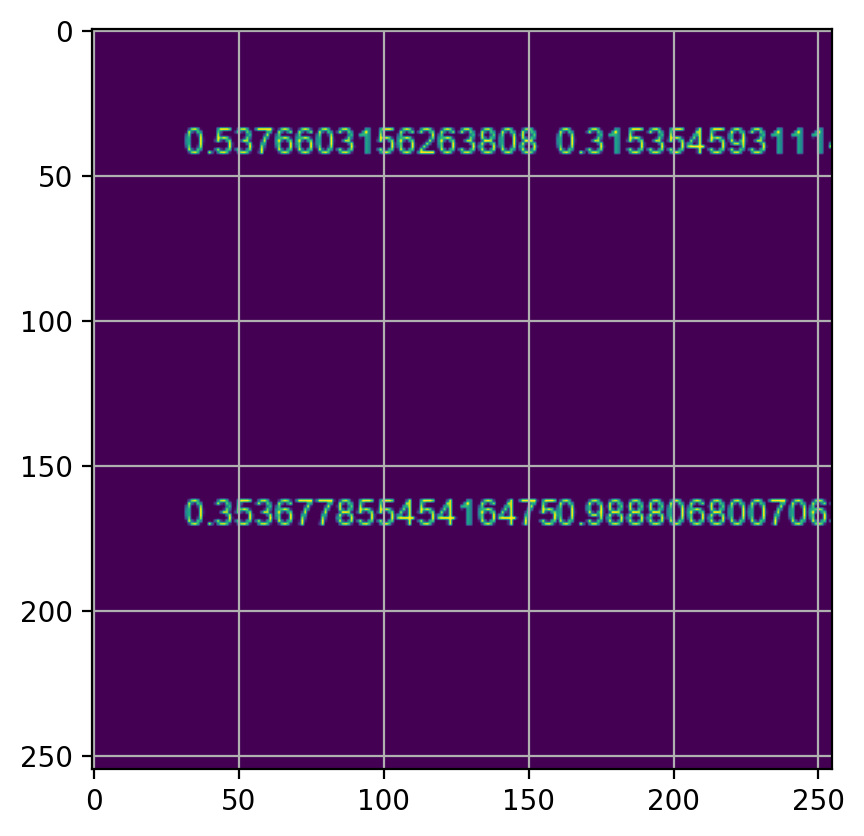

In [119]:
print(train_images.shape)
print(val_images.shape)
plt.grid()
plt.imshow(train_images[0][0, :, :])

plt.savefig('imagen_guardada.png')

----------

In [120]:
X_train = torch.from_numpy(train_images).float()
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(val_images).float()
y_val = torch.from_numpy(y_val).long()

In [121]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True),
              'val': DataLoader(val_dataset)}

dataset_sizes = {'train': len(X_train),
                'val': len(X_val)}

## Modeling
- Transfer Learning from Resnet
- I changed just fully connect layer at the end to 3 outputs

In [122]:
model = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


> Actually IT WORKS!!

In [123]:
best_model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=1)

EPOCH 1 / 1: 
----------
val Loss: 0.8728 Acc:  0.5200
Training COMPLETED: 0m 14s
BEST VALIDATION ACCURACY: 0.520000


## Further Experiments
One of my study group members was curious if the performance could be affected by the columns' positions. Let's check! I will change its position like below left to right and the other conditions are all same.

![compare.png](./compare.png)

result: Their Location doesn't matter with model performance

In [ ]:
from data_preparation import data_to_image_another

iris_data = load_iris()

X_train, X_val, y_train, y_val = train_test_split(iris_data.data, iris_data.target, stratify=iris_data.target, test_size=0.2, random_state=0)

train_images = data_to_image_another(X_train)
val_images = data_to_image_another(X_val)

print(train_images.shape)
print(val_images.shape)
plt.grid()
plt.imshow(train_images[0][0, :, :])

In [ ]:
X_train = torch.from_numpy(train_images).float()
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(val_images).float()
y_val = torch.from_numpy(y_val).long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True),
              'val': DataLoader(val_dataset)}

dataset_sizes = {'train': len(X_train),
                'val': len(X_val)}

model_another = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_another.parameters())

best_model = train_model(model_another, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=20)

---
I just coded for fun and curiosity, but this simple implementation gives very new insights of relation between tabular data and embeddings.